# Mask maker

In [1]:
import numpy as np
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

class MaskMaker:
    """
    MaskMaker class that creates image masks from random polygons.

    Attributes:
    -----------
    `seed` (int):
    The random number generator seed for reproducibility.
    `rng` (np.random.RandomState):
    An object used for handling the randomness in the class object.
    `nRegions` (int):
    Number of polygon regions.
    `xyTranslations` (list, tuple):
    List of tuples indicating x and y direction shifting of the polygon
    from origin.
    `polyEdges` (list, int):
    List of integers indicating the number of edges the polygon
    will have.
    `imageSize` (tuple):
    Size of the full image.
    `rescaler` (int):
    A factor of how much to enlarge each polygon by.
    `polygons` (list):
    A list of generated `matplotlib.patches.Polygon` objects.
    `rescaledVertices` (list):
    A list of list of vertices of the polygons after rescaling.
    `translatedVertices` (list):
    A list of list of translated vertices of the polygons after rescaling.
    `masks` (list):
    A list of `numpy.darray` objects which represent the mask for each polygon.
    `combinedMask` (numpy.darray):
    A single mask that is the combination of all the polygons.
    """
    def __init__(self, nRegions, xyTranslations,
               polyEdges, imageSize, randSeed, rescaler=10):
        """
        MaskMaker constructor

        Parameters:
        ----------
        `nRegions` (int):
          Number of polygon regions.
        `xyTranslations` (list, tuple):
          List of tuples indicating x and y direction shifting of the polygon
          from origin.
        `polyEdges` (list, int):
          List of integers indicating the number of edges the polygon
          will have.
        `imageSize` (tuple):
          Size of the full image.
        `rescaler` (int):
          Optional. A factor of how much to enlarge each polygon by.
          Default value is 10.
        """
        self.seed = randSeed
        self.rng = np.random.RandomState(self.seed)
        self.nRegions = nRegions
        self.xyTranslations = xyTranslations
        self.polyEdges = polyEdges
        self.imageSize = imageSize
        self.rescaler = rescaler
        self.polygons = self.generatePolygons()
        self.pVertices = self.getVertices()
        self.rescaledVertices = self.rescaleVertices(rescaler=self.rescaler)
        self.translatedVertices = self.translateVertices()
        self.masks = self.generateMasks()
        self.combinedMask = self.combineMasks()

    def generatePolygons(self):
        """
        Creates the polygons using matplotlib Polygons.
        """
        if isinstance(self.polyEdges, list):
            p = [Polygon(self.rng.rand(edge, 2), True) 
            for i, edge in zip(range(self.nRegions), self.polyEdges)]
        else:
            p = [Polygon(self.rng.rand(self.polyEdges, 2), True) 
            for i in range(self.nRegions)]
        return p

    def getVertices(self):
        """
        Extracts the points from the matplotlib Polygon objects.
        """
        vs = [p.get_path().vertices for p in self.polygons]
        ts = [p.get_patch_transform() for p in self.polygons]
        ppoints = [t.transform(v) for v, t in zip(vs,ts)]
        return ppoints

    def rescaleVertices(self, rescaler=10):
        """
        Rescales the size of the polygon
        """
        return [[[np.round(point*rescaler) for point in points]
                for points in pv] 
                 for pv in self.pVertices]

    def translateVertices(self):
        """
        Shifts the polygon in the x,y direction given `self.xyTranslations`
        """
        if isinstance(self.xyTranslations, list):
            tv = [[(np.round(x+xt), np.round(y+yt))  
                  for (x,y) in pv]
                   for pv, (xt,yt) 
                  in zip(self.rescaledVertices,self.xyTranslations)]
        else:
            tv = [[(np.round(x+self.xyTranslations[0]),
                  np.round(y+self.xyTranslations[1]))
                    for x,y in pv]
                    for pv in self.rescaledVertices]
        return tv

    def generateMasks(self):
        """
        Creates the masks from the polygons
        """
        width, height = self.imageSize
        masks = []
        for tv in self.translatedVertices:
            img = Image.new('L', (width, height), 0)
            ImageDraw.Draw(img).polygon(tv, outline=1, fill=1)
            mask = np.array(img)
            masks.append(mask)
        return masks

    def combineMasks(self):
        """
        Combines all the masks into a single mask
        which includes all the generated polygons.
        """
        cmask = np.logical_or.reduce(self.masks)
        return cmask
    
    def viewMask(self, maskNumber=None, plotComponents=False):
        """
        Method to display the polygon masks generated.

        Parameters:
        -----------
        `maskNumber` (int):
          Default `None`.
          Displays the combined mask when `None`.
          Displays the mask at index `maskNumber` when specified.

        `plotComponents` (bool):
          Default `False`.
          When `True`, the `fig`,`ax` for plotting will be returned;
          otherwise nothing will be returned.

        Returns:
        --------
        `matplotlib.figure.Figure`, `matplotlib.axes._subplots.AxesSubplot`
        """
        fig, ax = plt.subplots(figsize=(8,8))
        if maskNumber is None:
            plt.imshow(self.combinedMask)
        else:
            plt.imshow(self.masks[maskNumber])
        plt.axis('off')
        plt.show()
        if plotComponents:
            return fig, ax

**Set your own numbers**

In [2]:
mm = MaskMaker(
    nRegions=4,
    xyTranslations=[(60,55),(22,45),(55,75),(184,200)],
    polyEdges=[4,5,16,3],
    imageSize=(256,256),
    randSeed=1216137,
    rescaler=10
)

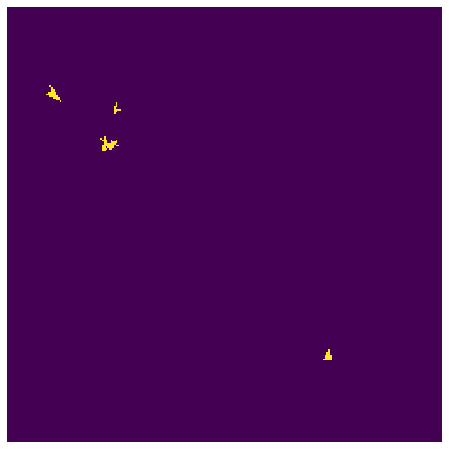

In [3]:
mm.viewMask()

**Generate random polygons**

In [4]:
np.random.seed(420)

In [5]:
random_positions = [(np.random.randint(256), np.random.randint(256)) for i in range(20)]
random_edges = [np.random.randint(3,8) for i in range(20)]

In [6]:
mm2 = MaskMaker(
    nRegions=15,
    xyTranslations=random_positions,
    polyEdges=random_edges,
    imageSize=(256,256),
    randSeed=420,
    rescaler=21
)

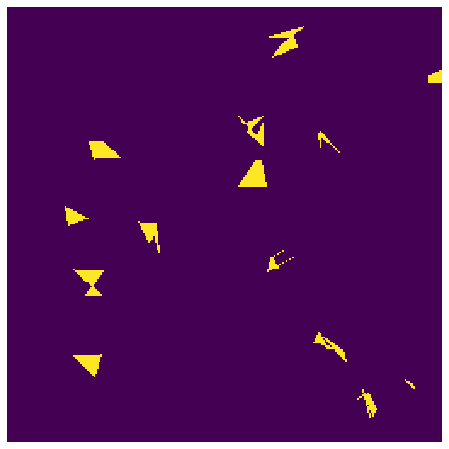

In [7]:
mm2.viewMask()